In [268]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier #Random Forest
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import random
from sklearn.ensemble import IsolationForest


In [269]:
def get_clf_eval(y_test , pred):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    # F1 스코어 추가
    f1 = f1_score(y_test,pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1:{3:.4f}, csi:{3:.4f}'.format(accuracy, precision, recall, f1))


In [270]:
def evaluate_macroF1_lgb(y_true, y_pred):  

    y_pred_label = np.round(y_pred)

    f1 = f1_score(y_true, y_pred_label, average='macro')

    print('f1 score:', f1)

    return ('f1_score', f1, True)

In [271]:
data = pd.read_csv('./지역치안안전 데이터.csv',encoding='CP949')

In [272]:
data['count'].value_counts()

0    1235645
1     104617
Name: count, dtype: int64

In [273]:
data['count'].value_counts()[1]/ (data['count'].value_counts()[0] + data['count'].value_counts()[1])

0.07805712614399274

## Label encoding

In [274]:
data.sido = pd.factorize(data.sido)[0]

categorical_var = ['code', 'season', 'sido']
for i in categorical_var:
    data[i] = data[i].astype('category')  

In [299]:
train = data[(data.YYYYMMDD<20221225)]
test  = data[data.YYYYMMDD>=20221225]

In [243]:
train_yes = train[train['count']==1]
train_no = train[train['count']==0]

<AxesSubplot:ylabel='count'>

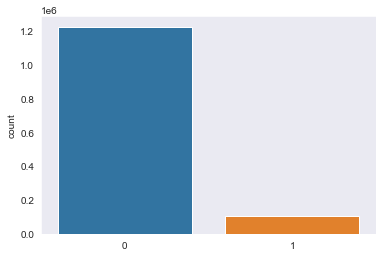

In [305]:
sns.barplot(x=train['count'].value_counts().index, y=train['count'].value_counts())


In [301]:
intcol = ['year', 'month', 'day',
       'hour', 'temp', 'wind', 'rainfall', 'pop', 'prop_older', 'avg_age',
       'num_school', 'season', 'count_AccRegion', 'SpeedLimit', 'num_cam',
       'num_DangerRegion', '1pRegion', 'Km2Cam', 'holiday', 'guess_car',
       'score']

c:\anaconda3\envs\osan\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\anaconda3\envs\osan\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\anaconda3\envs\osan\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level fun

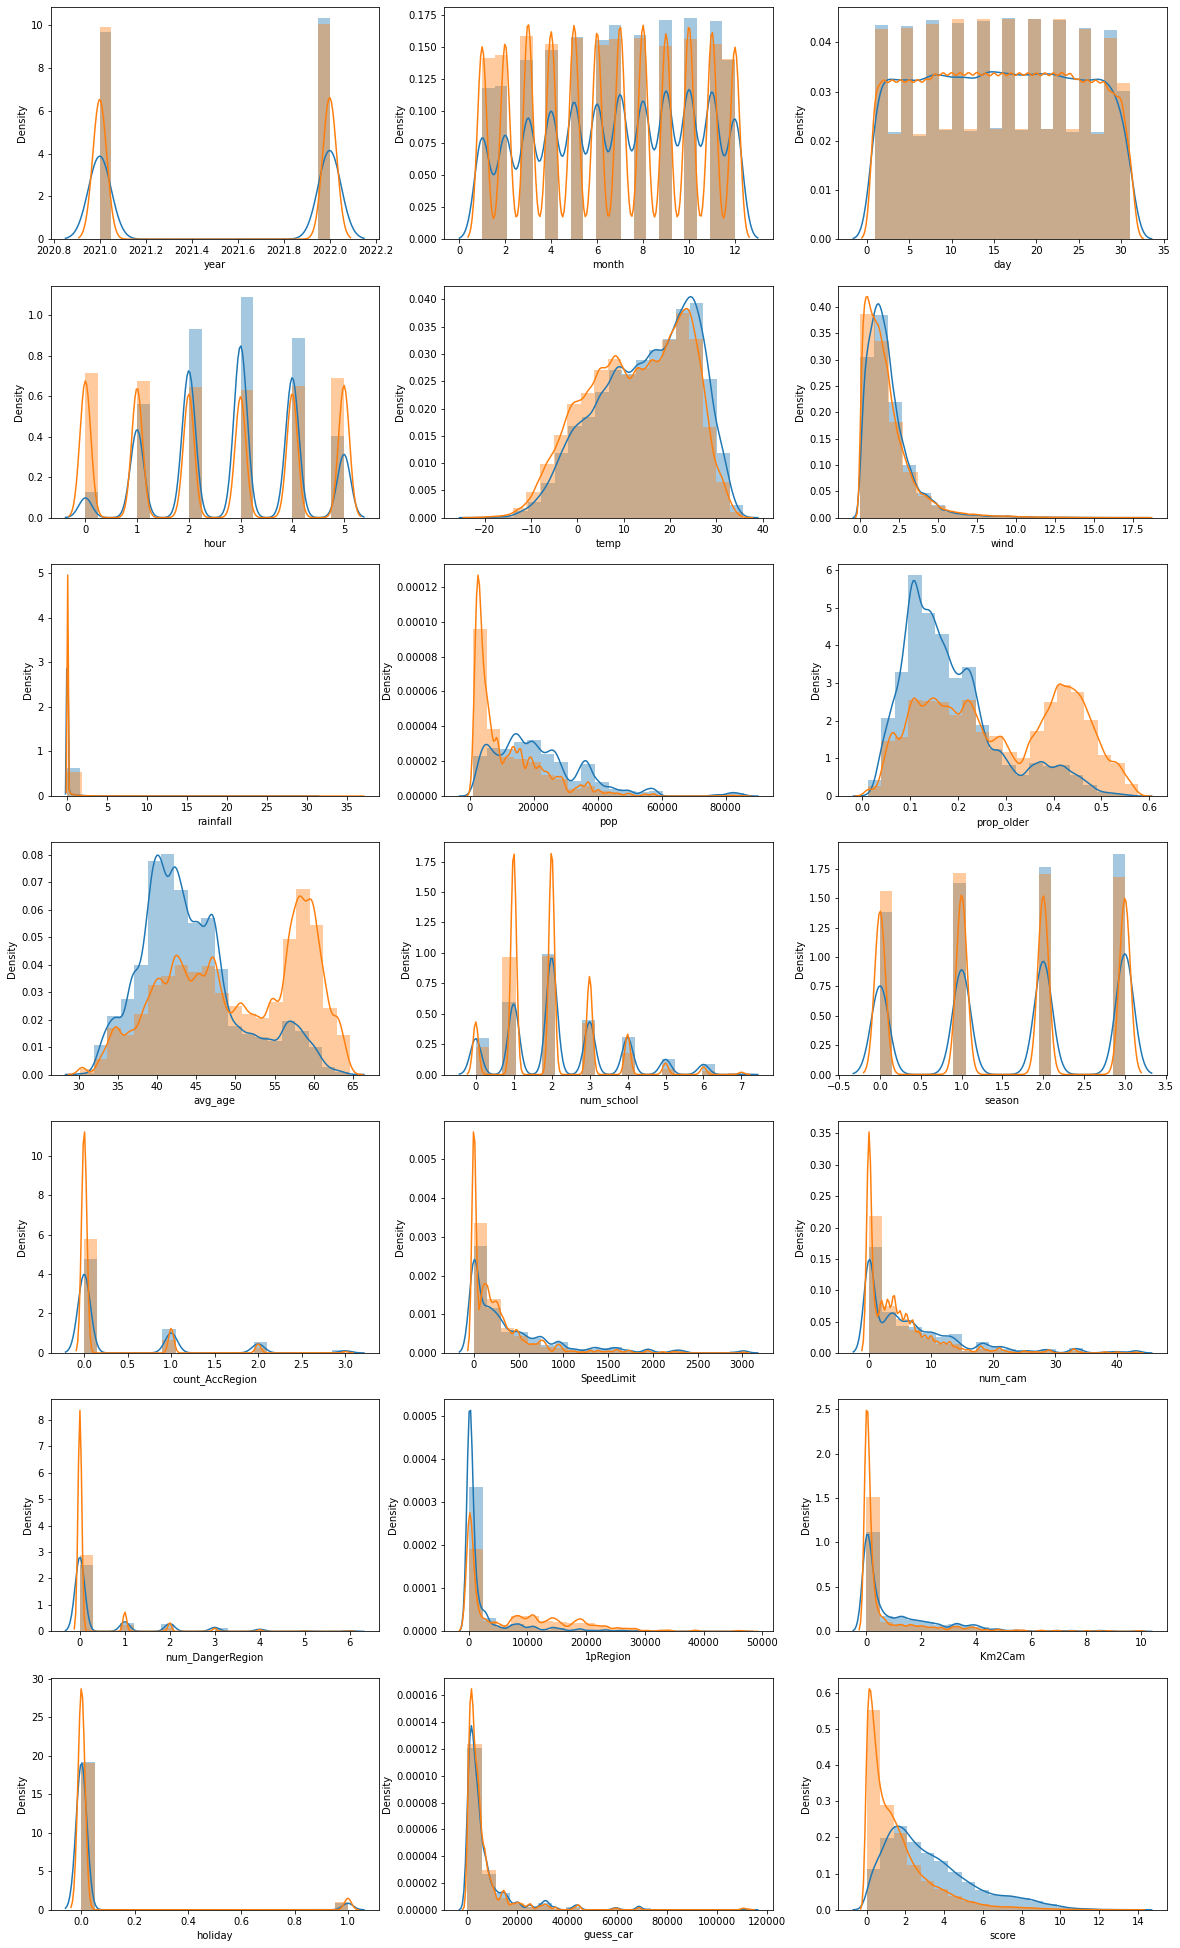

In [246]:

col_n = 3
row_n = 7

fig, ax = plt.subplots(ncols=col_n, nrows=row_n, figsize=(20,row_n*5))

# 파란색 bot, 노란색 notbot
for i,col in enumerate(intcol):
    sns.distplot(train_yes[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])
    sns.distplot(train_no[col], bins=20, ax=ax[int(i/col_n),int(i%col_n)])

plt.show()

In [302]:
train[intcol].corr()

,year,month,day,hour,temp,wind,rainfall,pop,prop_older,avg_age,num_school,count_AccRegion,SpeedLimit,num_cam,num_DangerRegion,1pRegion,Km2Cam,holiday,guess_car,score
year,1.000000e+00,-3.373525e-02,-2.688307e-02,5.451557e-16,-0.035291,0.049255,0.006828,1.104890e-04,2.642435e-02,2.421471e-02,-6.238953e-03,-6.331076e-03,5.977581e-02,1.617254e-02,-3.428057e-01,-4.090598e-04,-1.352881e-01,6.569704e-03,7.414463e-03,-5.387711e-02
month,-3.373525e-02,1.000000e+00,-3.109570e-02,1.053437e-16,0.222096,-0.059501,0.037742,-8.194769e-04,1.595849e-02,1.430656e-02,-2.455452e-03,-1.099248e-03,-2.891330e-03,-1.160700e-03,1.131625e-02,1.426005e-03,4.402314e-03,-1.325860e-03,3.892169e-03,5.405921e-02
day,-2.688307e-02,-3.109570e-02,1.000000e+00,-4.106077e-18,0.008577,0.000654,-0.015772,1.185998e-05,-1.398619e-03,-1.262198e-03,2.069943e-04,1.907262e-04,-1.590955e-03,-4.214301e-04,9.219256e-03,-9.876051e-05,3.640177e-03,-1.437281e-01,-3.317689e-04,-4.439582e-04
hour,5.451557e-16,1.053437e-16,-4.106077e-18,1.000000e+00,0.080992,0.052461,-0.009993,5.984240e-15,-1.263733e-14,-1.227325e-14,-4.995733e-15,-1.236657e-15,-1.395844e-14,-1.192088e-14,2.992166e-15,-1.035889e-14,2.915252e-15,5.943914e-18,1.552698e-15,3.692050e-15
temp,-3.529128e-02,2.220965e-01,8.576720e-03,8.099228e-02,1.000000,0.035474,0.097593,1.195014e-02,-5.917518e-03,-5.979731e-03,1.640184e-03,1.500192e-03,-8.631526e-03,-7.580568e-03,1.819915e-02,-1.354908e-02,1.703025e-02,2.660777e-02,2.244645e-03,9.246825e-02
wind,4.925474e-02,-5.950141e-02,6.537847e-04,5.246134e-02,0.035474,1.000000,0.044224,-8.768898e-02,9.559347e-02,9.592951e-02,5.019311e-02,6.794888e-03,1.317667e-01,1.428723e-01,-1.980620e-02,5.484021e-02,-6.127950e-02,1.615068e-02,-4.094786e-02,-6.500465e-02
rainfall,6.828215e-03,3.774191e-02,-1.577244e-02,-9.993145e-03,0.097593,0.044224,1.000000,-6.934842e-04,1.938749e-03,1.711499e-03,4.147469e-04,1.013260e-03,6.978924e-04,5.977957e-04,-2.736486e-03,1.676515e-03,-2.971957e-04,2.217820e-02,4.858485e-04,5.466931e-03
pop,1.104890e-04,-8.194769e-04,1.185998e-05,5.984240e-15,0.011950,-0.087689,-0.000693,1.000000e+00,-7.716171e-01,-7.895880e-01,2.842504e-01,2.709866e-01,4.366227e-01,4.250744e-01,2.430994e-01,-6.098732e-01,3.341527e-01,-1.252750e-04,6.684679e-02,7.593732e-01
prop_older,2.642435e-02,1.595849e-02,-1.398619e-03,-1.263733e-14,-0.005918,0.095593,0.001939,-7.716171e-01,1.000000e+00,9.913802e-01,-4.888082e-02,-1.999941e-01,-2.779923e-01,-3.075960e-01,-1.976251e-01,8.132267e-01,-4.248190e-01,3.774320e-04,-2.691648e-02,-6.208409e-01
avg_age,2.421471e-02,1.430656e-02,-1.262198e-03,-1.227325e-14,-0.005980,0.095930,0.001711,-7.895880e-01,9.913802e-01,1.000000e+00,-3.181048e-02,-1.974405e-01,-2.809713e-01,-3.092172e-01,-1.900896e-01,7.977465e-01,-4.222608e-01,3.728414e-04,1.329700e-04,-6.051366e-01


In [193]:
remove_var = ['address', 'prop_older', 'num_cam',  'YYYYMMDD', 'YYYYMM']
train.drop(remove_var,axis=1, inplace=True)
test.drop(remove_var, axis=1, inplace=True)

c:\anaconda3\envs\osan\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


## Log transform

In [276]:
intcol = ['year', 'month', 'day', 'hour', 'temp', 'wind',
       'rainfall', 'pop', 'avg_age', 'num_school', 'count_AccRegion',
       'SpeedLimit', 'num_DangerRegion', '1pRegion', 'Km2Cam', 'holiday',
       'guess_car', 'score']

In [288]:
for i in intcol:
    print("%s skew : %f, kurtosis : %f" % (i,train[i].skew(), train[i].kurt()))
    

year skew : -0.017153, kurtosis : -1.999709
month skew : -0.013956, kurtosis : -1.192694
day skew : 0.006372, kurtosis : -1.172465
hour skew : 0.000000, kurtosis : -1.268572
temp skew : -0.279874, kurtosis : -0.837198
wind skew : 2.490486, kurtosis : 10.046202
rainfall skew : 5.528601, kurtosis : 35.498444
pop skew : 1.706551, kurtosis : 4.180592
avg_age skew : -0.116540, kurtosis : -1.218749
num_school skew : 0.984176, kurtosis : 1.469787
count_AccRegion skew : 2.861130, kurtosis : 8.165054
SpeedLimit skew : 2.667010, kurtosis : 9.163694
num_DangerRegion skew : 2.645508, kurtosis : 6.243490
1pRegion skew : 1.212367, kurtosis : 1.134659
Km2Cam skew : 2.877216, kurtosis : 9.590221
holiday skew : 4.184891, kurtosis : 15.513333
guess_car skew : 0.026130, kurtosis : 0.301321
score skew : 1.813463, kurtosis : 3.957195


In [287]:
# 로그변환
log_var = ['rainfall', 'num_DangerRegion', 'guess_car']
for i in log_var:
    train[i] = np.log1p(train[i])
    test[i] = np.log1p(test[i])

c:\anaconda3\envs\osan\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
c:\anaconda3\envs\osan\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### Outlier Detect

In [160]:
# Outlier Detect

from collections import Counter

def detect_outliers(df, n, features):
    outlier_indices = [] 
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1 
        
        outlier_step = 1.5 * IQR 
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col) 
    outlier_indices = Counter(outlier_indices) 
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n) 
    
    return multiple_outliers

In [197]:
train_outlier = train[train['count']==0]
train2 = train[train['count']==1]

In [201]:
outlier_idx=detect_outliers(train_outlier, 5 , intcol)
train_outlier.drop(outlier_idx, axis=0, inplace=True)

c:\anaconda3\envs\osan\lib\site-packages\pandas\core\frame.py:4315: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [202]:
train = pd.concat([train2, train_outlier])

In [203]:
train.sort_values(['code','year','month', 'day', 'hour'], inplace=True)

# Modeling

In [204]:
random.seed(1234)
train_y = train['count']
train_x = train.drop(['count'],axis=1)
test_y = test['count']
test_x = test.drop(['count'],axis=1)

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, shuffle=True, test_size=0.2)

In [111]:
print(len(train_x),len(train_y))

165608 165608


# LGBMClassifier

In [112]:
lgb = LGBMClassifier(n_estimators = 500, learning_rate = 0.01, 
                      max_depth = 5,min_child_samples=100, n_jobs=-1, boost_from_average=False, categorical_feature = categorical_var)
lgb.fit(train_x, train_y, eval_set=[(train_x, train_y),(valid_x, valid_y)], eval_metric= evaluate_macroF1_lgb, 
         verbose= 100, early_stopping_rounds=100)

c:\anaconda3\envs\osan\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\anaconda3\envs\osan\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\anaconda3\envs\osan\lib\site-packages\lightgbm\basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `param

f1 score: 0.5903830538101303
f1 score: 0.2172848730062344
f1 score: 0.5903830538101303
f1 score: 0.2172574146019226
f1 score: 0.5903867855456904
f1 score: 0.21681885072033813
f1 score: 0.5903712760448885
f1 score: 0.21740712721553948
f1 score: 0.5903890975263675
f1 score: 0.2165384269558182
f1 score: 0.5912091247528688
f1 score: 0.23455533807022075
f1 score: 0.5916129846828935
f1 score: 0.23397675231632253
f1 score: 0.5993244382321391
f1 score: 0.23778428341727867
f1 score: 0.5993577276609245
f1 score: 0.2387570148245063
f1 score: 0.6011014085315851
f1 score: 0.2410977123101236
f1 score: 0.5994982515687022
f1 score: 0.2383382976020375
f1 score: 0.601144504947237
f1 score: 0.24041004951488504
f1 score: 0.6001148735092299
f1 score: 0.23937185014498658
f1 score: 0.6000671358865366
f1 score: 0.23944449410118882
f1 score: 0.6003091147835111
f1 score: 0.23876605015519398
f1 score: 0.6002970868640599
f1 score: 0.23869627547944894
f1 score: 0.6013309198198773
f1 score: 0.238192935346027
f1 sco

LGBMClassifier(boost_from_average=False, categorical_feature=['code', 'season'],
               learning_rate=0.01, max_depth=5, min_child_samples=100,
               n_estimators=500)

In [113]:
pred_y_valid = lgb.predict(valid_x)

In [114]:
get_clf_eval(valid_y , pred_y_valid)

오차 행렬
[[ 47988 196193]
 [  7540  13151]]
정확도: 0.2308, 정밀도: 0.0628, 재현율: 0.6356, F1:0.1143, csi:0.1143


In [115]:
pred_y_test = lgb.predict(test_x)

In [116]:
get_clf_eval(test_y , pred_y_test)

오차 행렬
[[ 1268 10714]
 [  253   869]]
정확도: 0.1631, 정밀도: 0.0750, 재현율: 0.7745, F1:0.1368, csi:0.1368


In [117]:
a=pd.DataFrame(data=lgb.predict_proba(valid_x)[:,1],columns={'prob1'})
pred1=np.where(a['prob1'] >= a['prob1'].mean(), 1, 0)
print(pred1.sum())

131702


In [118]:
get_clf_eval(pred1, valid_y)

오차 행렬
[[116031  17139]
 [128150   3552]]
정확도: 0.4515, 정밀도: 0.1717, 재현율: 0.0270, F1:0.0466, csi:0.0466


In [122]:
b=pd.DataFrame(data=lgb.predict_proba(test_x)[:,1],columns={'prob1'})
pred2=np.where(b['prob1'] >= a['prob1'].mean(), 1, 0)
print(pred2.sum())

4462


In [123]:
get_clf_eval(pred2, test_y)

오차 행렬
[[8340  302]
 [3642  820]]
정확도: 0.6990, 정밀도: 0.7308, 재현율: 0.1838, F1:0.2937, csi:0.2937


# RandomForest

In [134]:
rf = RandomForestClassifier(n_estimators=500,n_jobs=-1)
rf.fit(train_x, train_y)

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [139]:
a=pd.DataFrame(data=rf.predict_proba(valid_x)[:,1],columns={'prob1'})
pred1=np.where(a['prob1'] >= 0.2, 1, 0)
print(pred1.sum())

36057


In [140]:
a['prob1'].mean()

0.08318911021172493

In [141]:
get_clf_eval(pred1, valid_y)

오차 행렬
[[216134  12681]
 [ 28168   7889]]
정확도: 0.8458, 정밀도: 0.3835, 재현율: 0.2188, F1:0.2786, csi:0.2786


In [144]:
b=pd.DataFrame(data=rf.predict_proba(test_x)[:,1],columns={'prob1'})
pred2=np.where(b['prob1'] >= 0.2, 1, 0)
print(pred2.sum())

1905


In [145]:
get_clf_eval(pred2, test_y)

오차 행렬
[[10521   678]
 [ 1461   444]]
정확도: 0.8368, 정밀도: 0.3957, 재현율: 0.2331, F1:0.2934, csi:0.2934


# XGBoostClassifier

In [205]:
for i in categorical_var:
    train_x[i] = train_x[i].astype('int64')
    valid_x[i] = valid_x[i].astype('int64')
    test_x[i] = test_x[i].astype('int64')



In [241]:
xgb = XGBClassifier(n_estimators = 1000, learning_rate = 0.001, 
                      max_depth = 5, n_jobs=-1)
xgb.fit(train_x, train_y, eval_set=[(train_x, train_y),(valid_x, valid_y)])

[0]	validation_0-logloss:0.69241	validation_1-logloss:0.69241
[1]	validation_0-logloss:0.69167	validation_1-logloss:0.69167
[2]	validation_0-logloss:0.69093	validation_1-logloss:0.69093
[3]	validation_0-logloss:0.69020	validation_1-logloss:0.69020
[4]	validation_0-logloss:0.68946	validation_1-logloss:0.68946
[5]	validation_0-logloss:0.68873	validation_1-logloss:0.68873
[6]	validation_0-logloss:0.68800	validation_1-logloss:0.68800
[7]	validation_0-logloss:0.68727	validation_1-logloss:0.68727
[8]	validation_0-logloss:0.68654	validation_1-logloss:0.68654
[9]	validation_0-logloss:0.68582	validation_1-logloss:0.68581
[10]	validation_0-logloss:0.68509	validation_1-logloss:0.68509
[11]	validation_0-logloss:0.68437	validation_1-logloss:0.68437
[12]	validation_0-logloss:0.68365	validation_1-logloss:0.68364
[13]	validation_0-logloss:0.68292	validation_1-logloss:0.68292
[14]	validation_0-logloss:0.68221	validation_1-logloss:0.68220
[15]	validation_0-logloss:0.68149	validation_1-logloss:0.68148
[1

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.001, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [235]:
a=pd.DataFrame(data=xgb.predict_proba(valid_x)[:,1],columns={'prob1'})
pred1=np.where(a['prob1'] >= 0.2, 1, 0)
print(pred1.sum())

26803


In [236]:
get_clf_eval(valid_y,pred1)

오차 행렬
[[224969  19233]
 [ 13100   7570]]
정확도: 0.8779, 정밀도: 0.2824, 재현율: 0.3662, F1:0.3189, csi:0.3189


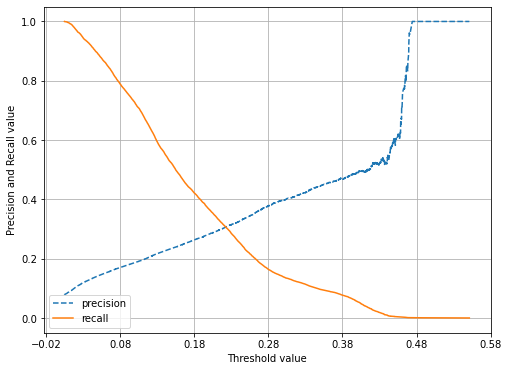

In [218]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
  
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
  
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
  
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
  
precision_recall_curve_plot(valid_y, xgb.predict_proba(valid_x)[:,1] )

In [212]:
get_clf_eval(pred1, valid_y)

오차 행렬
[[224969  13100]
 [ 19233   7570]]
정확도: 0.8779, 정밀도: 0.3662, 재현율: 0.2824, F1:0.3189, csi:0.3189


In [223]:
b=pd.DataFrame(data=xgb.predict_proba(test_x)[:,1],columns={'prob1'})
pred2=np.where(b['prob1'] >= 0.2, 1, 0)
print(pred2.sum())

1185


In [226]:
get_clf_eval(pred2, test_y)

오차 행렬
[[11153   766]
 [  829   356]]
정확도: 0.8783, 정밀도: 0.3173, 재현율: 0.3004, F1:0.3086, csi:0.3086


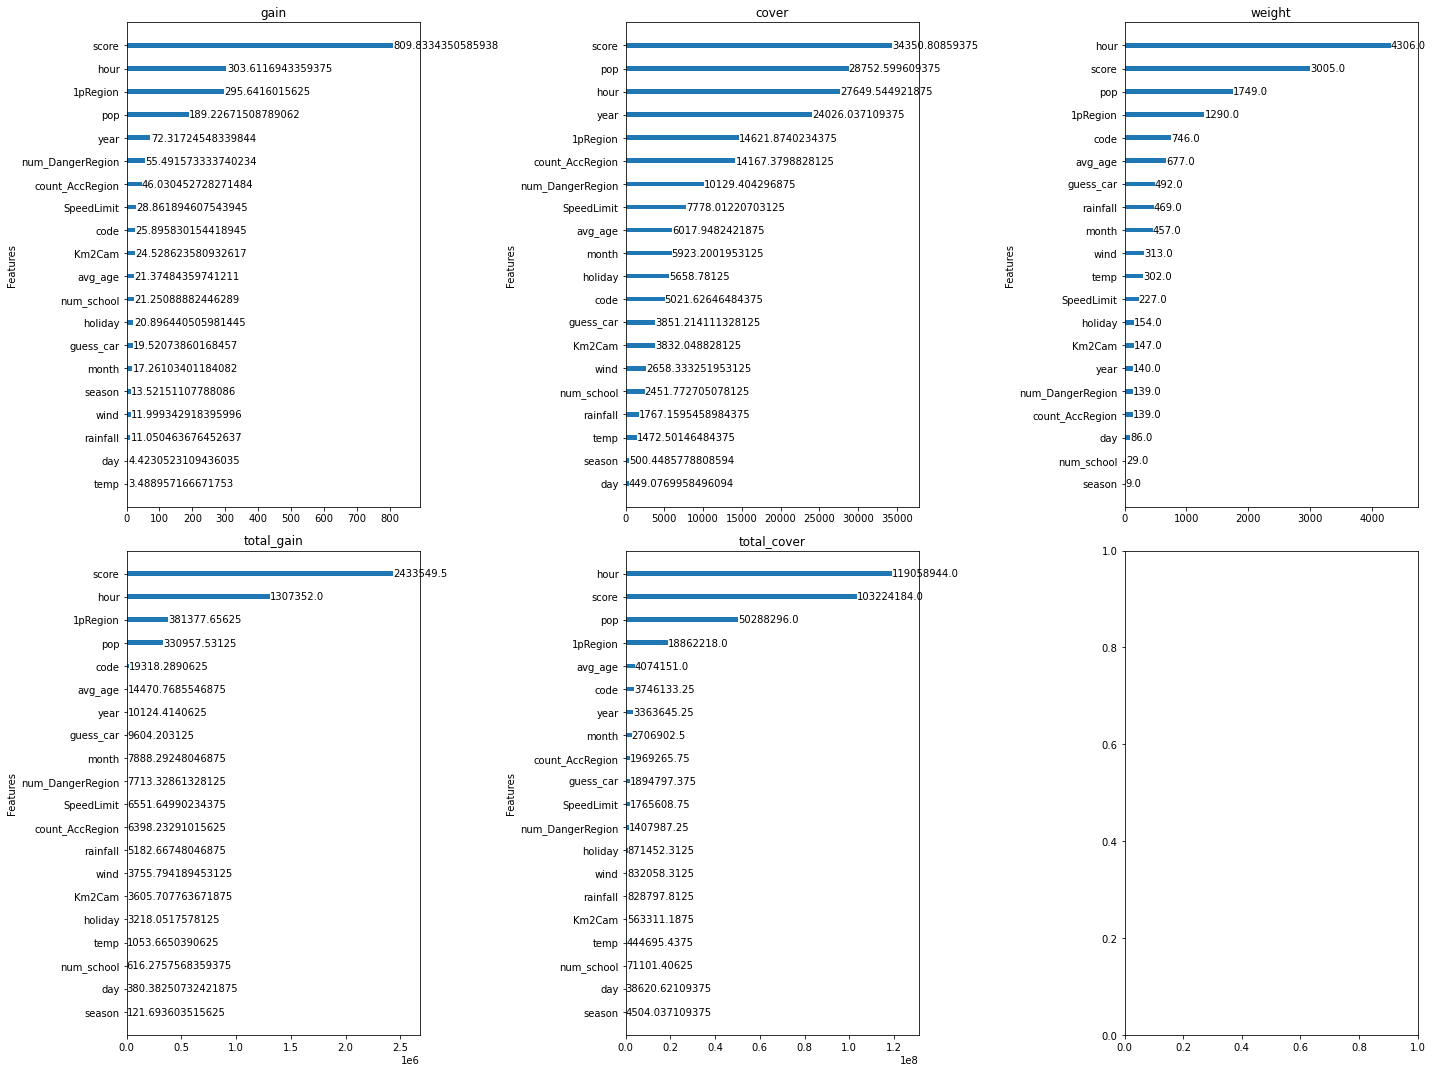

In [240]:
import xgboost
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20,15))

axes = [ax for row_axes in axes for ax in row_axes]

xgboost.plot_importance(xgb, importance_type='gain', title='gain', xlabel='', grid=False, ax=axes[0])
xgboost.plot_importance(xgb, importance_type='cover', title='cover', xlabel='', grid=False, ax=axes[1])
xgboost.plot_importance(xgb, importance_type='weight', title='weight', xlabel='', grid=False, ax=axes[2])
xgboost.plot_importance(xgb, importance_type='total_gain', title='total_gain', xlabel='', grid=False, ax=axes[3])
xgboost.plot_importance(xgb, importance_type='total_cover', title='total_cover', xlabel='', grid=False, ax=axes[4])
plt.tight_layout()
plt.show()

In [229]:
test_ = test_x.copy()
test_['predict_proba'] = xgb.predict_proba(test_x)[:,1]

In [231]:
test_.to_csv('./test_predict.csv',encoding='CP949')